<a href="https://colab.research.google.com/github/gladcolor/place_connectivity/blob/master/place_connectivity_v2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install packages

In [1]:
pip install geopandas

     |████████████████████████████████| 1.0MB 14.0MB/s 
     |████████████████████████████████| 6.6MB 23.7MB/s 
     |████████████████████████████████| 15.4MB 341kB/s 


# Import pacakges

In [8]:
import pandas as pd
import geopandas as gpd
import scipy


import scipy
import pandas as pd
import pandas as pd
import sklearn
from sklearn.cluster import AgglomerativeClustering
import numpy as np
import numba as nb
from numba import jit
from natsort import natsorted
import os
import scipy

from natsort import natsorted
from scipy.linalg import norm
from PIL import Image, ImageDraw
import plotly.express as px
import json
from urllib.request import urlopen

from tqdm import tqdm

# Prepare data

## Download PCI data

In [3]:
us_county_pci_2019_file = r'https://github.com/GIBDUSC/Place-Connectivity-Index/raw/main/US_County_PCI_2019.zip'
us_county_pci_2019_df = pd.read_csv(us_county_pci_2019_file, dtype={"place_i":str, "place_j":str})
us_county_pci_2019_df

# us_county_pci_2018_file = r'https://github.com/GIBDUSC/Place-Connectivity-Index/raw/main/US_County_PCI_2018.zip'
# us_county_pci_2018_df = pd.read_csv(us_county_pci_2018_file, dtype={"place_i":str, "place_j":str})



,place_i,place_j,shared_users,place_i_users,place_j_users,pci,dir_pci
0,24015,40075,1,6379,126,1.115,7.937
1,37185,47189,3,233,6203,2.495,0.484
2,19111,08017,1,511,29,8.215,34.483
3,19015,56019,1,737,258,2.293,3.876
4,20121,47119,2,651,3753,1.280,0.533
...,...,...,...,...,...,...,...
3949846,51139,16001,2,744,13666,0.627,0.146
3949847,51013,13105,3,51081,230,0.875,13.043
3949848,42015,55045,1,607,566,1.706,1.767
3949849,42033,22059,1,1220,224,1.913,4.464


## Filter users

In [4]:
tweet_user_min = 5

us_county_pci_2019_file = r'https://github.com/GIBDUSC/Place-Connectivity-Index/raw/main/US_County_PCI_2019.zip'


csv_file = us_county_pci_2019_file

df = pd.read_csv(csv_file, dtype={"place_i":str, "place_j":str})
print("Rows count before filtering:", len(df))

gby_o = df.groupby('place_i')['place_i'].count().index.to_list()
gby_d = df.groupby('place_j')['place_j'].count().index.to_list()
gby = gby_o + gby_d
gby_list = gby_o + gby_d
gby_set = set(gby_list)
gby_list = list(gby_set)
place_list = natsorted(gby_list)
print("Place counts (before filtering): ", len(place_list))
print()


# fitler
print("tweet_user_min:", tweet_user_min)
df = pd.read_csv(csv_file, dtype={"place_i":str, "place_j":str})

df = df[df['place_i'] != df['place_j']]
df = df[df['place_i_users'] > tweet_user_min]
df = df[df['place_j_users'] > tweet_user_min]
print("Rows count after filtering:", len(df))

gby_o = df.groupby('place_i')['place_i'].count().index.to_list()
gby_d = df.groupby('place_j')['place_j'].count().index.to_list()
gby = gby_o + gby_d
gby_list = gby_o + gby_d
gby_set = set(gby_list)
gby_list = list(gby_set)
place_list = natsorted(gby_list)
print("Place counts (after filtering): ", len(place_list))

Rows count before filtering: 3405113
Place counts (before filtering):  3107

tweet_user_min: 5
Rows count after filtering: 3399082
Place counts (after filtering):  3082


## build distance matrix


In [5]:
dis_mat = np.zeros((len(place_list[:]), len(place_list[:])))
print("dis_mat shape:", dis_mat.shape) 
print()

place_dic = {}                
for i in range(len(place_list[:])):
#     print(i, gby_list[i])
    place_dic[place_list[i]] = i
# print(fips_dic)

print("place dictionary: ")
print("idx, key, place_dic[key] (first 10 items):")
for idx, key in enumerate(list(place_dic.keys())[:10]):
    print(idx, key, place_dic[key])
    
print()
print("idx, key, place_dic[key] (last 10 items):")
for idx, key in enumerate(list(place_dic.keys())[-10:]):
    print(idx, key, place_dic[key])

dis_mat shape: (3082, 3082)

place dictionary: 
idx, key, place_dic[key] (first 10 items):
0 01001 0
1 01003 1
2 01005 2
3 01007 3
4 01009 4
5 01011 5
6 01013 6
7 01015 7
8 01017 8
9 01019 9

idx, key, place_dic[key] (last 10 items):
0 56027 3072
1 56029 3073
2 56031 3074
3 56033 3075
4 56035 3076
5 56037 3077
6 56039 3078
7 56041 3079
8 56043 3080
9 56045 3081


## Create matrix

May need minutes, please wait.

In [14]:
print("May need minutes, please wait...\n")

for idx, row in df.iterrows():
    interval = 100000
    i = place_dic[row['place_i']]
    j = place_dic[row['place_j']]
    i = int(i)
    j = int(j)
    dis_mat[i, j] = row['pci']
    dis_mat[j, i] = row['pci']

    
    if idx % interval == 0:        
        print(f"Processed: {idx} / {len(df)} rows, {idx/len(df) * 100 :.0f}%\n")
        print("idx, i, j, dis_mat[i, j], dis_mat[j, i], row['place_i'], row['place_j']")
        print(idx, i, j, dis_mat[i, j], dis_mat[j, i], row['place_i'], row['place_j'])
        print()
    if i == j:
        dis_mat[j, i] = 0
        
print("done")

May need minutes, please wait...

Processed: 0 / 3399082 rows, 0%

idx, i, j, dis_mat[i, j], dis_mat[j, i], row['place_i'], row['place_j']
0 2028 2880 1.209 1.209 39087 51730

Processed: 100000 / 3399082 rows, 3%

idx, i, j, dis_mat[i, j], dis_mat[j, i], row['place_i'], row['place_j']
100000 495 1527 1.232 1.232 13279 29169

Processed: 200000 / 3399082 rows, 6%

idx, i, j, dis_mat[i, j], dis_mat[j, i], row['place_i'], row['place_j']
200000 562 2532 3.2239999999999998 3.2239999999999998 17005 48141

Processed: 300000 / 3399082 rows, 9%

idx, i, j, dis_mat[i, j], dis_mat[j, i], row['place_i'], row['place_j']
300000 70 464 1.138 1.138 04007 13217

Processed: 400000 / 3399082 rows, 12%

idx, i, j, dis_mat[i, j], dis_mat[j, i], row['place_i'], row['place_j']
400000 1289 377 1.1420000000000001 1.1420000000000001 27027 13039

Processed: 500000 / 3399082 rows, 15%

idx, i, j, dis_mat[i, j], dis_mat[j, i], row['place_i'], row['place_j']
500000 2121 282 0.583 0.583 40097 09007

Processed: 600000

In [17]:
print("dis_mat.max(), dis_mat.min():", (dis_mat.max(), dis_mat.min()))
dis_mat_inv = 1 / (dis_mat/1000 + 0.0000001)
print("dis_mat_inv:\n", dis_mat_inv) 
conn_mat = np.where(dis_mat > 0, 1, 0)

dis_mat.max(), dis_mat.min(): (446.685, 0.0)
dis_mat_inv:
 [[1.00000000e+07 2.57200985e+01 4.87493358e+01 ... 9.04895485e+02
  4.24790791e+02 4.08814030e+02]
 [2.57200985e+01 1.00000000e+07 7.78749484e+01 ... 4.41481612e+02
  1.00000000e+07 1.00000000e+07]
 [4.87493358e+01 7.78749484e+01 1.00000000e+07 ... 1.00000000e+07
  1.00000000e+07 1.00000000e+07]
 ...
 [9.04895485e+02 4.41481612e+02 1.00000000e+07 ... 1.00000000e+07
  1.74638934e+02 1.68149182e+02]
 [4.24790791e+02 1.00000000e+07 1.00000000e+07 ... 1.74638934e+02
  1.00000000e+07 1.00000000e+07]
 [4.08814030e+02 1.00000000e+07 1.00000000e+07 ... 1.68149182e+02
  1.00000000e+07 1.00000000e+07]]


## Prepare map data

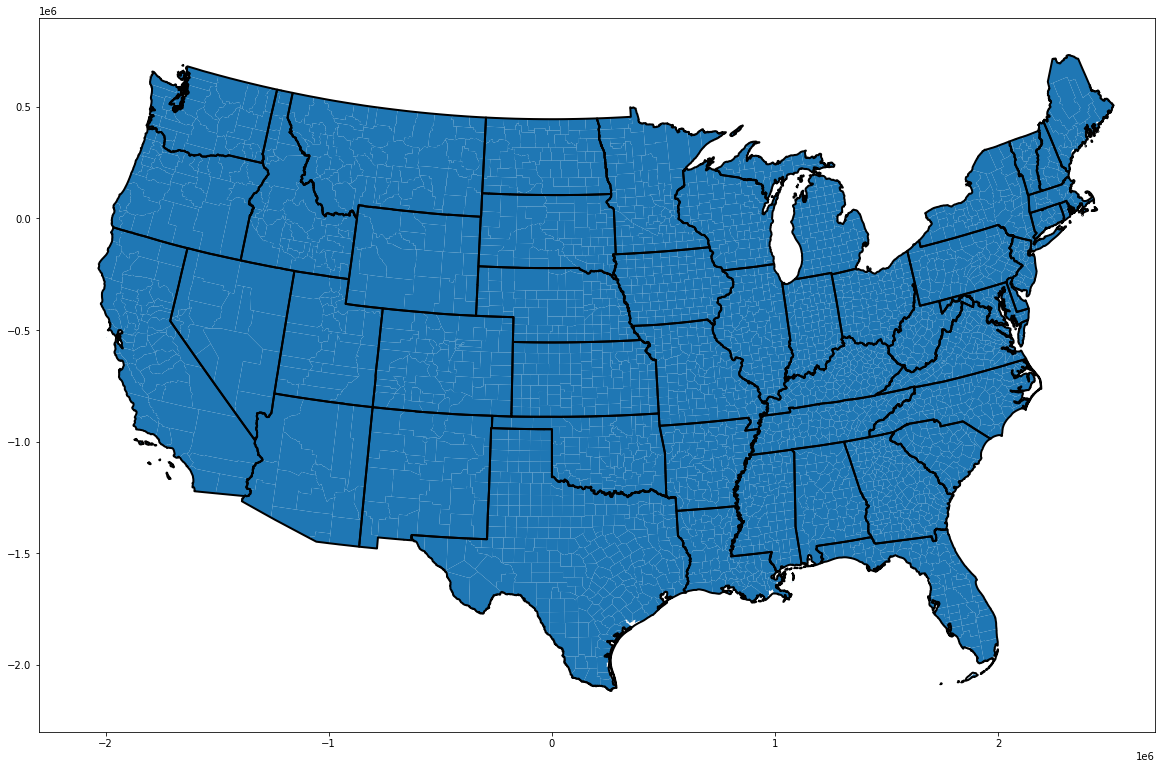

In [24]:
import matplotlib.pyplot as plt

state_shp_file = r'https://github.com/gladcolor/place_connectivity/raw/master/cb_2018_us_state_5m.zip'
gdf_state = gpd.read_file(state_shp_file)

county_shp_file = r'https://github.com/gladcolor/place_connectivity/raw/master/us_counties.zip'
gdf_counties = gpd.read_file(county_shp_file)
gdf_counties['county_code'] = gdf_counties['FIPS'].str[2:]

plot_projection = 'EPSG:2163'
fig, ax = plt.subplots(figsize=(20, 15))
plt.xlim([-2300000, 2700000])
plt.ylim([-2300000, 900000])
gdf_counties.to_crs(plot_projection).plot(ax=ax)
gdf_state.to_crs(plot_projection).plot(ax=ax, facecolor="none", edgecolor="black", linewidth=2)

# Agglomerative clustering 

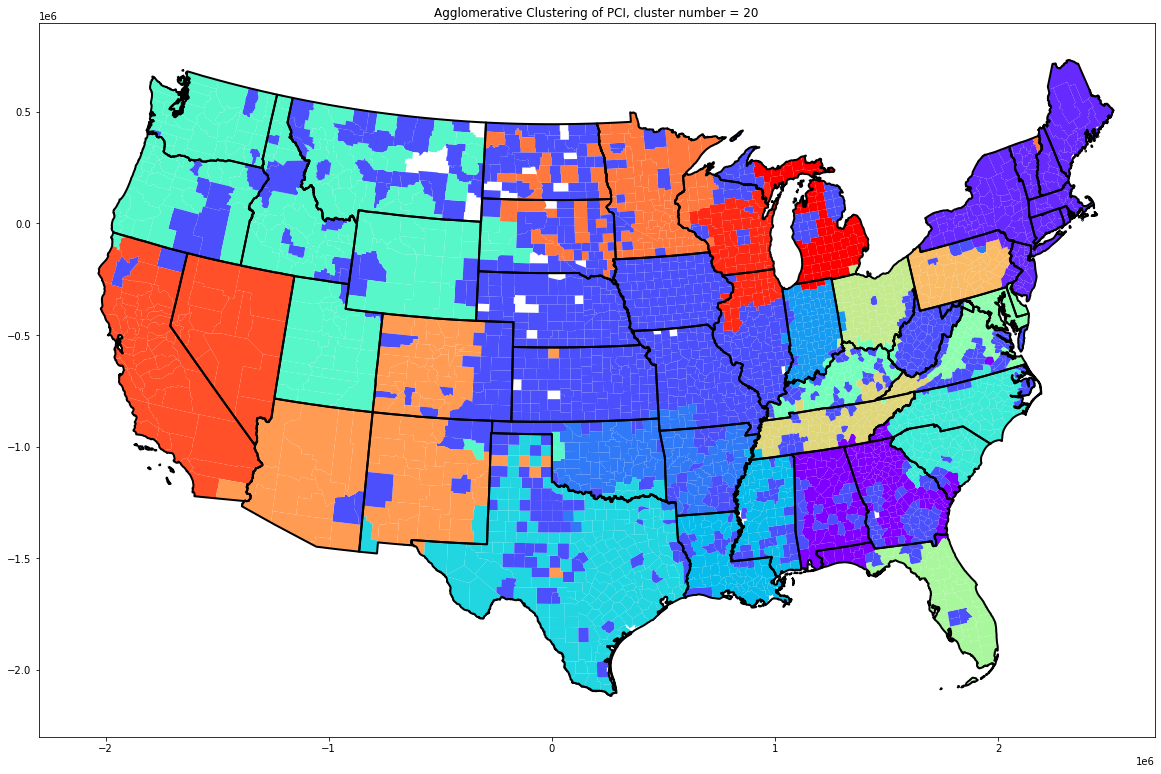

finished  20


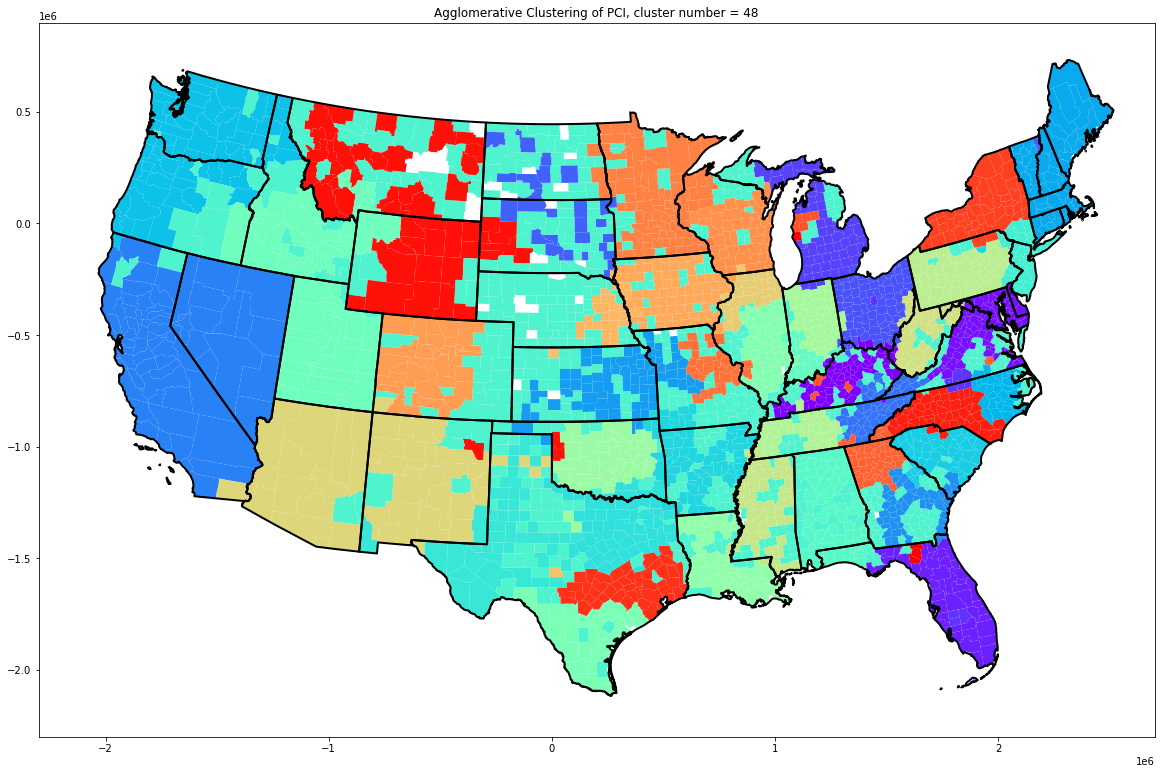

finished  48


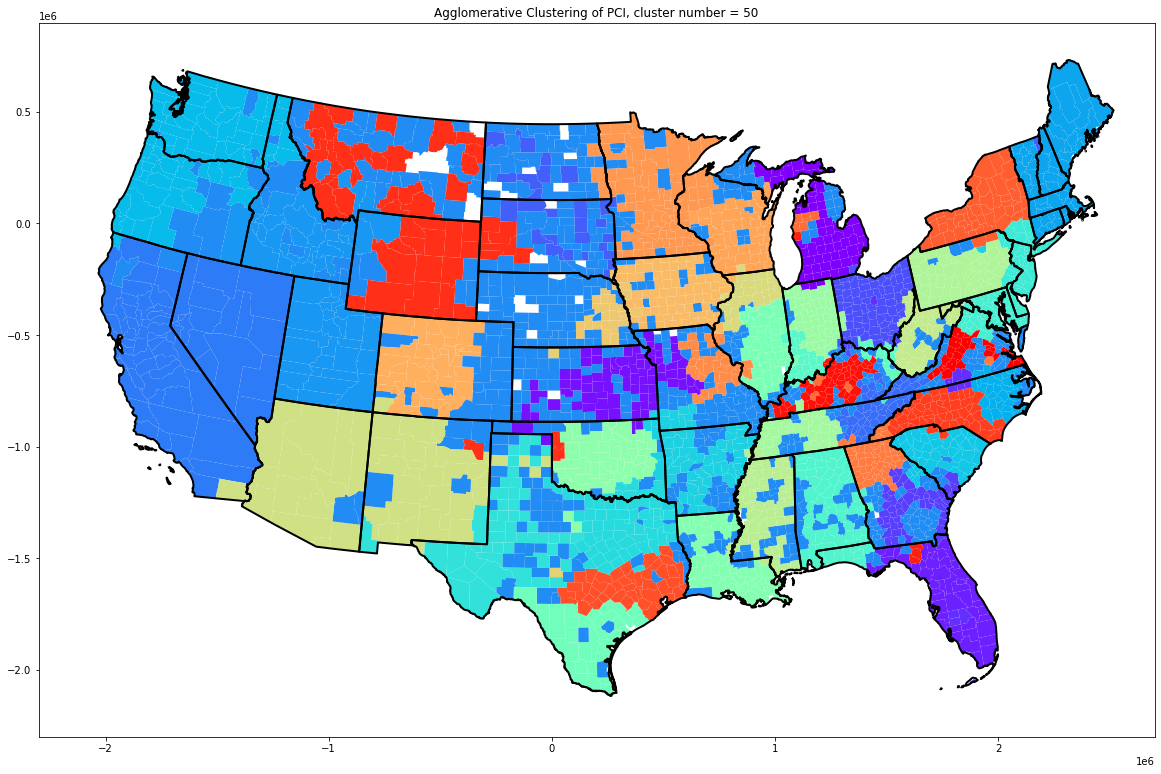

finished  50


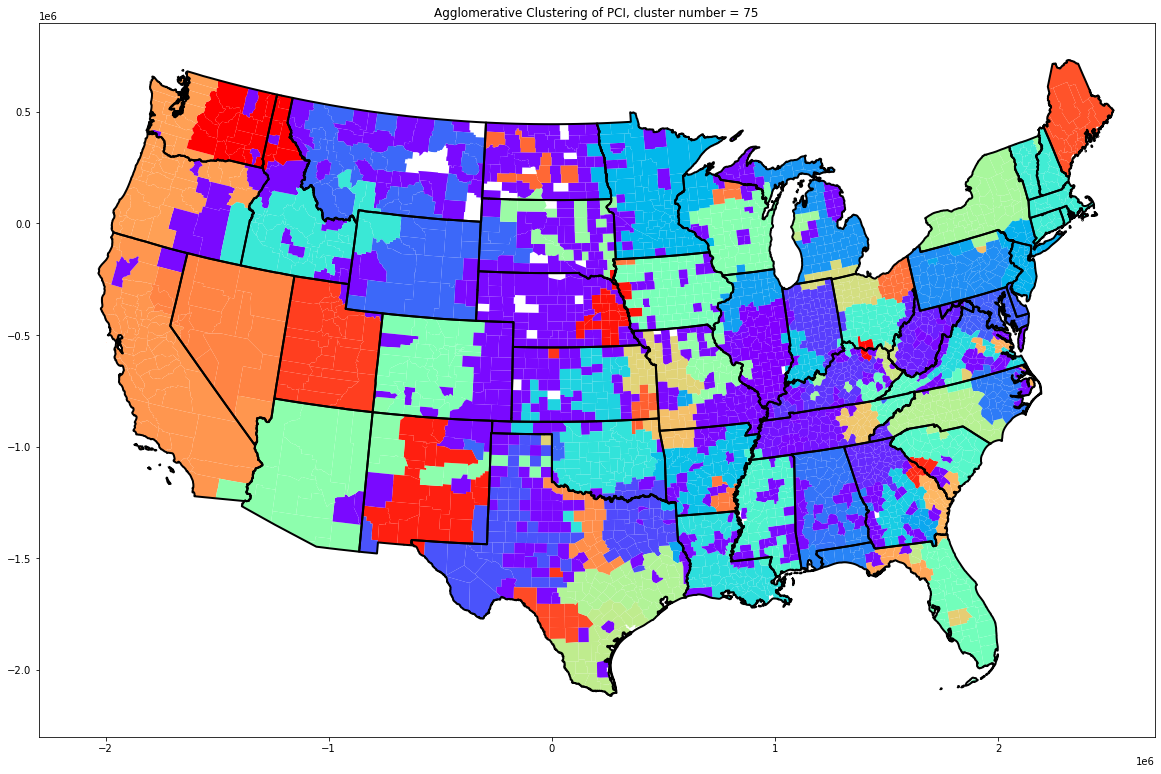

finished  75


In [28]:
df_re_list = []

n_cluster_cnts = [20, 48, 50, 75]
# n_cluster_cnts = [20]

results_df = pd.DataFrame(list(zip(place_list)), columns =['place'])
for n in n_cluster_cnts:
    name = "n_" + str(n)
    results_df[name] = -1

for n_clusters in n_cluster_cnts:
# for n_clusters in (5, ):
    clustering = AgglomerativeClustering(n_clusters=n_clusters,  affinity="precomputed", linkage='average', \
                                       connectivity=conn_mat).fit(dis_mat_inv)


    fips_col = []
    for idx, label in enumerate(clustering.labels_[:]):
        # print(gby_list[idx], label)
        
        fips_col.append(gby_list[idx])

#     df_re = pd.DataFrame(list(zip(fips_col, clustering.labels_[:])), columns=['fips', 'class'])
    name = "n_" + str(n_clusters)
    results_df[name] = clustering.labels_

    df_re_list.append(results_df)

    
    # draw map
    plot_projection = 'EPSG:2163'
    fig, ax = plt.subplots(figsize=(20, 15))
    plt.xlim([-2300000, 2700000])
    plt.ylim([-2300000, 900000])
    plt.title(f"Agglomerative Clustering of PCI, cluster number = {n_clusters}")

    merged_gdf = pd.merge(gdf_counties, results_df, how='left', left_on='county_code', right_on='place')    
    merged_gdf.to_crs(plot_projection).plot(ax=ax, column=name, cmap='rainbow')
    gdf_state.to_crs(plot_projection).plot(ax=ax, facecolor="none", edgecolor="black", linewidth=2)

    new_file = os.path.basename(csv_file).replace(".zip", f"_agglomerative_{n_clusters}.png")
    fig.savefig(new_file)
    plt.show()

    print("finished n_clusters =", n_clusters)

new_file = os.path.basename(csv_file).replace(".zip", f"_agglomerative_{n_clusters}.csv")
results_df.to_csv(new_file, index=False)
 


